In [1]:
# Keras
import keras
from keras import regularizers
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, Model, model_from_json
from keras.layers import Dense, Embedding, LSTM
from keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.utils import np_utils
from keras.callbacks import (EarlyStopping, LearningRateScheduler,
                             ModelCheckpoint, TensorBoard, ReduceLROnPlateau)
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import optimizers
from keras import losses, models
from keras.activations import relu, softmax
from keras.layers import (Convolution2D, GlobalAveragePooling2D, BatchNormalization, Flatten, Dropout,
                          GlobalMaxPool2D, MaxPool2D, concatenate, Activation, Input, Dense)
from tensorflow.keras.layers import Input, Dense, Convolution2D, MaxPooling2D, UpSampling2D, Flatten, Reshape, Dropout, Conv2D
# sklearn
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Other  
from tqdm import tqdm, tqdm_pandas
import scipy
from scipy.stats import skew
import pickle
import librosa
import librosa.display
import json
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.pyplot import specgram
import pandas as pd
import seaborn as sns
import glob 
import os
import sys
import IPython.display as ipd  # To play sound in the notebook
import warnings
# ignore warnings 
if not sys.warnoptions:
    warnings.simplefilter("ignore")

In [2]:
ref = pd.read_csv("../dataset/audio_data_path.csv")
ref.head()

,labels,source,path
0,m_surprise,SAVEE,../dataset/savee/AudioData/DC/su02.wav
1,m_happy,SAVEE,../dataset/savee/AudioData/DC/h07.wav
2,m_happy,SAVEE,../dataset/savee/AudioData/DC/h14.wav
3,m_disgust,SAVEE,../dataset/savee/AudioData/DC/d02.wav
4,m_disgust,SAVEE,../dataset/savee/AudioData/DC/d11.wav


In [3]:
from sentiment_until import prepare_data

sampling_rate=44100
audio_duration=2.5
n_mfcc = 32
mfcc = prepare_data(ref, n_mfcc, sampling_rate, audio_duration, n_mfcc)

100%|██████████| 1920/1920 [01:01<00:00, 31.00it/s]


In [4]:
mfcc.shape

(1920, 32, 216, 1)

In [5]:
# Split between train and test 
X_train, X_test, y_train, y_test = train_test_split(mfcc
                                                    , ref.labels
                                                    , test_size=0.25
                                                    , shuffle=True
                                                    , random_state=42
                                                   )


# one hot encode the target 
lb = LabelEncoder()
y_train_old = y_train
y_train = np_utils.to_categorical(lb.fit_transform(y_train))
y_test = np_utils.to_categorical(lb.fit_transform(y_test))

# Pickel the lb object for future use 
filename = 'labels_2D'
outfile = open('./model/'+filename,'wb')
pickle.dump(lb,outfile)
outfile.close()

# Normalization as per the standard NN process
mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)

X_train = (X_train - mean)/std
X_test = (X_test - mean)/std

print(X_train.shape)
X_train_label = X_train.reshape(X_train.shape[0], X_train.shape[1]*X_train.shape[2], 1)
print(X_train_label.shape)
print(mfcc.shape)
print(y_train_old.shape)

(1440, 32, 216, 1)
(1440, 6912, 1)
(1920, 32, 216, 1)
(1440,)


In [6]:
X_train[0].shape

(32, 216, 1)

In [7]:
lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               verbose=1,
                               min_lr=0.5e-6)
callbacks = [lr_reducer]

In [17]:
# Build CNN model 
from sentiment_until import get_2d_conv_model
model = get_2d_conv_model(n=n_mfcc)
model_history = model.fit(X_train, y_train, validation_data=(X_test, y_test), 
                    batch_size=32, verbose = 1, epochs=100, callbacks=callbacks)

Epoch 1/100
45/45 [==============================] - 9s 198ms/step - loss: 2.5706 - acc: 0.1694 - val_loss: 2.2051 - val_acc: 0.2792 - lr: 0.0010
Epoch 2/100
45/45 [==============================] - 9s 193ms/step - loss: 2.1800 - acc: 0.2604 - val_loss: 2.2028 - val_acc: 0.2646 - lr: 0.0010
Epoch 3/100
45/45 [==============================] - 9s 194ms/step - loss: 1.9918 - acc: 0.3167 - val_loss: 2.2392 - val_acc: 0.2729 - lr: 0.0010
Epoch 4/100
45/45 [==============================] - 9s 196ms/step - loss: 1.8995 - acc: 0.3632 - val_loss: 2.3362 - val_acc: 0.2313 - lr: 0.0010
Epoch 5/100
45/45 [==============================] - 9s 203ms/step - loss: 1.7937 - acc: 0.3910 - val_loss: 2.0610 - val_acc: 0.3083 - lr: 0.0010
Epoch 6/100
45/45 [==============================] - 9s 193ms/step - loss: 1.6994 - acc: 0.4014 - val_loss: 2.0356 - val_acc: 0.2854 - lr: 0.0010
Epoch 7/100
45/45 [==============================] - 9s 194ms/step - loss: 1.5686 - acc: 0.4396 - val_loss: 1.7071 - val_acc

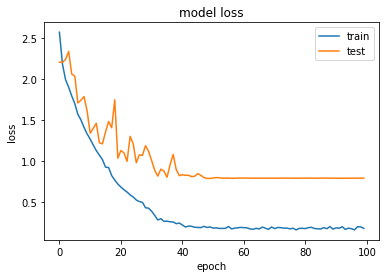

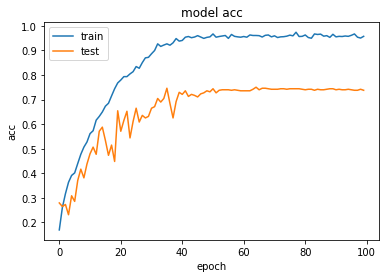

In [18]:
from sentiment_until import get_results
results = get_results(model_history,model,X_test,y_test, ref.labels.unique())
results.create_plot(model_history)
results.create_plot_acc(model_history)


accuracy: 73.75%
30/30 - 0s - 478ms/epoch - 16ms/step


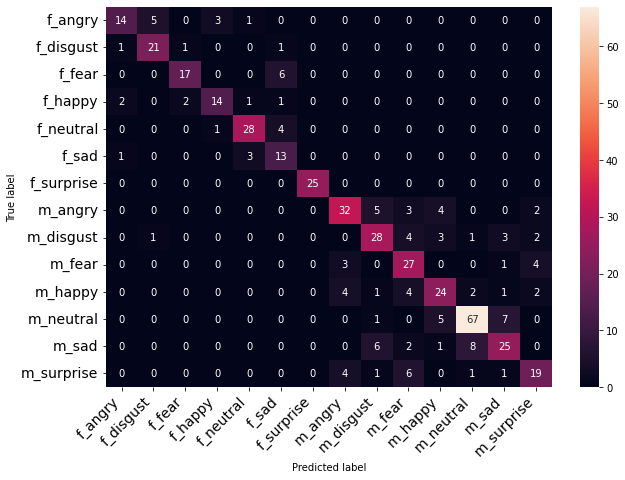

In [19]:
results.create_results(model)
results.confusion_results(X_test, y_test, ref.labels.unique(), model)

In [20]:
# Save model and weights
model_name = 'model_2D.h5'
save_dir = "./model/"

model_path = save_dir + model_name
model.save(model_path)
print('Save model and weights at %s ' % model_path)

# Save the model to disk
model_json = model.to_json()
with open("./model/model_json_2D.json", "w") as json_file:
    json_file.write(model_json)

Save model and weights at ./model/model_2D.h5 


## auto encoder train

In [9]:
# Split between train and test 
X1_train, X1_test, y1_train, y1_test = train_test_split(mfcc
                                                    , mfcc
                                                    , test_size=0.25
                                                    , shuffle=True
                                                    , random_state=42
                                                   )

# Normalization as per the standard NN process
mean = np.mean(X1_train, axis=0)
std = np.std(X1_train, axis=0)

X1_train = (X1_train - mean)/std
X1_test = (X1_test - mean)/std

mean1 = np.mean(y1_train, axis=0)
std1 = np.std(y1_train, axis=0)
y1_train = (y1_train - mean1)/std1
y1_test = (y1_test - mean1)/std1

print(X1_train.shape)
print(y1_train.shape)
print(X1_test.shape)
print(y1_test.shape)

(1440, 32, 216, 1)
(1440, 32, 216, 1)
(480, 32, 216, 1)
(480, 32, 216, 1)


In [10]:
# Build auto encoder model 
from sentiment_until import get_2d_conv_auto_encoder
model = get_2d_conv_auto_encoder(n=n_mfcc)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               verbose=1,
                               min_lr=0.5e-6)
callbacks = [lr_reducer]



2022-05-07 22:05:11.648362: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-07 22:05:11.648840: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-07 22:05:11.651493: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcusolver.so.11'; dlerror: libcusolver.so.11: cannot open shared object file: No such file or directory
2022-05-07 22:05:11.651834: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory
2022-05-07 22:05:11.651842: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU 

In [123]:
model_history = model.fit(X1_train, X1_train, validation_data=(X1_test, X1_test), 
                    batch_size=32, verbose = 1, epochs=1, callbacks=callbacks)

45/45 [==============================] - 109s 2s/step - loss: 1.1852 - getCosAcc: 0.3927 - val_loss: 1.4802 - val_getCosAcc: 0.2242 - lr: 0.0010


In [124]:
model_history

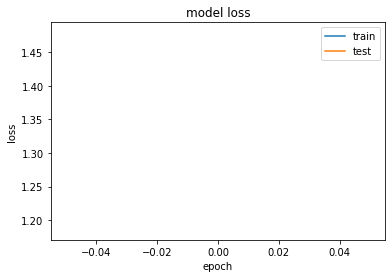

In [125]:
results = get_results(model_history,model,X_test,X_test, ref.labels.unique())
results.create_plot(model_history)

In [126]:
# Save model and weights
model_name = 'model_2D_auto_encoder.h5'
save_dir = "./model/"

model_path = save_dir + model_name
model.save(model_path)
print('Save model and weights at %s ' % model_path)

# Save the model to disk
model_json = model.to_json()
with open("./model/model_json_2D_auto_encoder.json", "w") as json_file:
    json_file.write(model_json)


Save model and weights at ./model/model_2D_auto_encoder.h5 


In [11]:
# loading json and model architecture 
json_file = open('./model/model_json_2D_auto_encoder.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

# load weights into new model
loaded_model.load_weights("./model/model_2D_auto_encoder.h5")
print("Loaded model from disk")
 
# Keras optimiser
opt = optimizers.Adam(0.001)
loaded_model.compile(optimizer=opt, loss="mean_squared_error", metrics=['acc'])

Loaded model from disk


In [20]:
preds = loaded_model.predict(X_train, 
                         batch_size=32, 
                         verbose=1)


45/45 [==============================] - 3s 69ms/step


In [13]:
X_test.reshape(X_test.shape[0], -1).shape


(480, 6912)

In [21]:
import tensorflow as tf
from keras import backend as K
#效率低
def getCosAcc(predict, label):
    acc = K.mean(-tf.losses.cosine_similarity(label.reshape(label.shape[0], -1).tolist(), 
    predict.reshape(predict.shape[0], -1).tolist(), axis=1))
    return acc
tfAcc = getCosAcc(X_train, preds)
print(tfAcc)

def getCosAcc1(predict, label):
    acc = 0
    sum = 0
    for i in range(predict.shape[0]):
        sum += cosine_similarity(predict[i].reshape(1, -1), label[i].reshape(1, -1))
    acc = sum / predict.shape[0]
    return acc
tfAcc1 = getCosAcc1(X_train, preds)
print(tfAcc1)


tf.Tensor(0.643217, shape=(), dtype=float32)
[[0.64321707]]


In [22]:
print(X_train.shape)
print(preds.shape)
pred = preds[42].reshape(32, 216)
print(pred.shape)


orignal = X_train[42].reshape(32, 216)
print(orignal.shape)
# Cosine Loss
from sklearn.metrics.pairwise import cosine_similarity
sum = 0
maxSim = 0
maxIndex = 0
#效率高
for i in range(X_train.shape[0]):
    temp = cosine_similarity(X_train[i].reshape(1, -1), preds[i].reshape(1, -1))
    if temp >= maxSim:
        maxIndex = i
    maxSim = max(temp, maxSim)
    sum += temp
    

res = sum / X_train.shape[0]
print(maxIndex)
res

(1440, 32, 216, 1)
(1440, 32, 216, 1)
(32, 216)
(32, 216)
42


array([[0.64321707]])

In [23]:
cosine_similarity(X_train[42].reshape(1, -1), preds[42].reshape(1, -1))

array([[0.81065327]])

Text(0.5, 1.0, 'MFCC sepc')

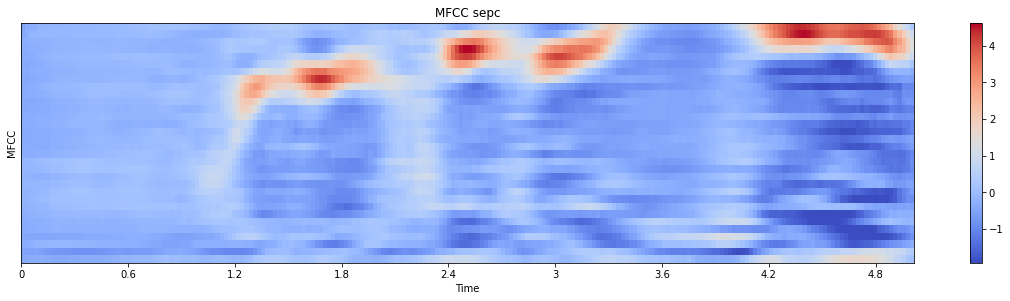

In [24]:
# MFCC
plt.figure(figsize=(20, 15))
plt.subplot(3,1,1)
librosa.display.specshow(pred, x_axis='time')
plt.ylabel('MFCC')
plt.colorbar()
plt.title('MFCC sepc')

Text(0.5, 1.0, 'MFCC sepc')

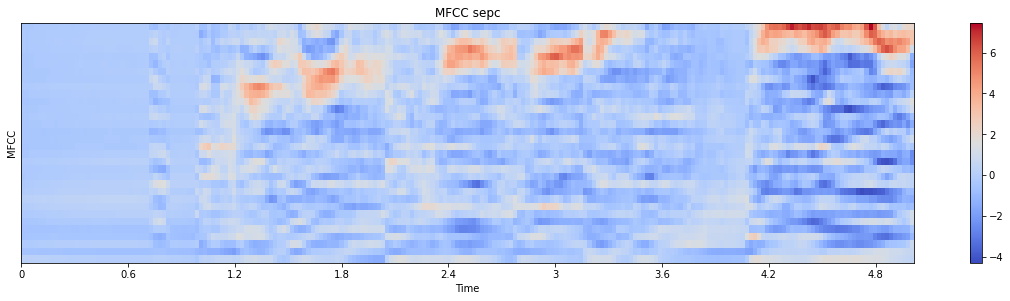

In [25]:
# MFCC
plt.figure(figsize=(20, 15))
plt.subplot(3,1,1)
librosa.display.specshow(orignal, x_axis='time')
plt.ylabel('MFCC')
plt.colorbar()
plt.title('MFCC sepc')

## obtain audio embedding

In [146]:
encoded_layer_model = Model(inputs=loaded_model.input,
                                     outputs=loaded_model.get_layer('encoded').output)
#out put predict value of the model
encoded_output = encoded_layer_model.predict(X_train)

In [147]:
print(encoded_output.shape)

(1440, 4, 27, 1)


In [148]:
encoded_output[0][0][26]

array([-0.40230078], dtype=float32)

### processing audio embedding，generate table correlated to the label

In [149]:
temp = encoded_output.reshape(encoded_output.shape[0], encoded_output.shape[1]*encoded_output.shape[2])
temp

array([[-0.5042811 , -0.4273646 , -0.5195569 , ..., -0.37171525,
        -0.199839  , -0.18628612],
       [-0.11098281, -0.10388979, -0.06318212, ...,  0.07009163,
         0.5536978 ,  0.01135027],
       [-0.10138667, -0.14669478, -0.1275151 , ...,  0.87680054,
         0.8449521 ,  0.43905357],
       ...,
       [ 0.4831338 ,  0.39316884,  0.39980066, ..., -0.00210522,
        -0.36448878, -0.44736058],
       [-0.3646794 , -0.29082012, -0.31242394, ..., -0.24297321,
        -0.37800515, -0.35150355],
       [-0.48204774, -0.41725224, -0.2557448 , ..., -0.4008683 ,
        -0.27058402, -0.36276764]], dtype=float32)

In [150]:
label_temp = np.array(y_train_old)
label_temp[1]

'f_sad'

In [151]:
label_temp = label_temp.reshape(label_temp.shape[0], 1)
label_temp

array([['m_neutral'],
       ['f_sad'],
       ['f_neutral'],
       ...,
       ['m_surprise'],
       ['m_neutral'],
       ['m_neutral']], dtype=object)

In [152]:
label_df = pd.DataFrame(label_temp)
label_df.head()

,0
0,m_neutral
1,f_sad
2,f_neutral
3,m_fear
4,m_neutral


In [153]:
em_df = pd.DataFrame(temp)
em_df.head()

,0,1,2,3,4,5,6,7,8,9,...,98,99,100,101,102,103,104,105,106,107
0,-0.504281,-0.427365,-0.519557,-0.629859,-0.629859,-0.519913,-0.629859,-0.556203,-0.605106,-0.592489,...,-0.430297,-0.399582,-0.075815,-0.135701,-0.004715,-0.189843,0.161181,-0.371715,-0.199839,-0.186286
1,-0.110983,-0.103890,-0.063182,-0.114516,-0.112650,-0.172134,-0.225444,-0.192116,-0.175435,0.001059,...,-0.163251,0.155345,-0.007225,0.039680,-0.186692,0.047228,0.170926,0.070092,0.553698,0.011350
2,-0.101387,-0.146695,-0.127515,-0.158159,-0.172775,-0.212269,-0.242705,-0.179039,-0.182775,-0.149124,...,0.667429,0.881873,0.712925,0.744448,0.596081,0.673980,0.845208,0.876801,0.844952,0.439054
3,-0.155329,-0.124418,-0.243442,-0.107044,-0.413908,-0.117588,-0.001165,-0.186451,-0.499862,-0.426585,...,0.200291,0.068006,0.034221,0.183618,0.210933,0.145808,-0.020882,-0.095218,-0.226382,-0.253818
4,-0.392306,-0.315623,-0.441369,-0.353499,-0.290997,-0.454479,-0.442850,-0.479907,-0.629859,-0.266194,...,0.247008,0.219731,0.275426,0.211315,0.314326,0.270123,0.117642,0.074828,-0.188160,-0.292886


In [154]:
em_out_df = pd.concat([label_df, em_df], axis = 1)
em_out_df.head()

,0,0,1,2,3,4,5,6,7,8,...,98,99,100,101,102,103,104,105,106,107
0,m_neutral,-0.504281,-0.427365,-0.519557,-0.629859,-0.629859,-0.519913,-0.629859,-0.556203,-0.605106,...,-0.430297,-0.399582,-0.075815,-0.135701,-0.004715,-0.189843,0.161181,-0.371715,-0.199839,-0.186286
1,f_sad,-0.110983,-0.103890,-0.063182,-0.114516,-0.112650,-0.172134,-0.225444,-0.192116,-0.175435,...,-0.163251,0.155345,-0.007225,0.039680,-0.186692,0.047228,0.170926,0.070092,0.553698,0.011350
2,f_neutral,-0.101387,-0.146695,-0.127515,-0.158159,-0.172775,-0.212269,-0.242705,-0.179039,-0.182775,...,0.667429,0.881873,0.712925,0.744448,0.596081,0.673980,0.845208,0.876801,0.844952,0.439054
3,m_fear,-0.155329,-0.124418,-0.243442,-0.107044,-0.413908,-0.117588,-0.001165,-0.186451,-0.499862,...,0.200291,0.068006,0.034221,0.183618,0.210933,0.145808,-0.020882,-0.095218,-0.226382,-0.253818
4,m_neutral,-0.392306,-0.315623,-0.441369,-0.353499,-0.290997,-0.454479,-0.442850,-0.479907,-0.629859,...,0.247008,0.219731,0.275426,0.211315,0.314326,0.270123,0.117642,0.074828,-0.188160,-0.292886


In [155]:
em_out_df.to_csv("../dataset/audio_embedding.csv",index=False)

In [156]:
em_out_df = pd.read_csv("../dataset/audio_embedding.csv")
em_out_df.head()

,0,0.1,1,2,3,4,5,6,7,8,...,98,99,100,101,102,103,104,105,106,107
0,m_neutral,-0.504281,-0.427365,-0.519557,-0.629859,-0.629859,-0.519913,-0.629859,-0.556203,-0.605106,...,-0.430297,-0.399582,-0.075815,-0.135701,-0.004715,-0.189843,0.161181,-0.371715,-0.199839,-0.186286
1,f_sad,-0.110983,-0.103890,-0.063182,-0.114516,-0.112650,-0.172134,-0.225444,-0.192116,-0.175435,...,-0.163251,0.155345,-0.007225,0.039680,-0.186692,0.047228,0.170926,0.070092,0.553698,0.011350
2,f_neutral,-0.101387,-0.146695,-0.127515,-0.158159,-0.172775,-0.212269,-0.242705,-0.179039,-0.182775,...,0.667429,0.881873,0.712925,0.744448,0.596081,0.673980,0.845208,0.876801,0.844952,0.439054
3,m_fear,-0.155329,-0.124418,-0.243442,-0.107044,-0.413908,-0.117588,-0.001165,-0.186451,-0.499862,...,0.200291,0.068006,0.034221,0.183618,0.210933,0.145808,-0.020882,-0.095218,-0.226382,-0.253818
4,m_neutral,-0.392306,-0.315623,-0.441369,-0.353499,-0.290997,-0.454479,-0.442850,-0.479907,-0.629859,...,0.247008,0.219731,0.275426,0.211315,0.314326,0.270123,0.117642,0.074828,-0.188160,-0.292886
